In [2]:
import requests
import pandas as pd

import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.geocoders import Nominatim

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library



In [4]:
!pip install beautifulsoup4
from bs4 import BeautifulSoup

     |████████████████████████████████| 122kB 16.3MB/s eta 0:00:01


<H2> Scraping the wikipedia page

In [10]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html_data = requests.get(url).text
soup = BeautifulSoup(html_data, 'html5lib')

<H2>Cleaning and wrangling

In [8]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

Explanation of process:  

1. Retrieve the URL and create a Beautiful soup object

2. Create a list 

3. After finding the table and table data, create a dictionary called cell having 3 keys: PostalCode, Borough and Neighborhood

4. As postal code contains upto 3 characters extract that using tablerow.p.text

5. Use split, strip, and replace functions to extract Borough and Neighborhood information

6. Append to the list

7. Create a dataframe with list

In [14]:
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [15]:
df.shape

(103, 3)

<H2>Creating dataframe with geospatial coordinates from provided csv file

In [20]:
coordinates = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv")
coordinates.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [23]:
#Merging geospatial data with existing neighborhood dataframe

coordinates.rename(columns={"Postal Code": "PostalCode"}, inplace=True)
df = df.join(coordinates.set_index('PostalCode'), on='PostalCode')
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


<H2> Generating map of Toronto with markers for each neighborhood

In [28]:
# create map of Toronto using latitude and longitude values
address = 'Toronto'
geolocator = Nominatim(user_agent="toronto-explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

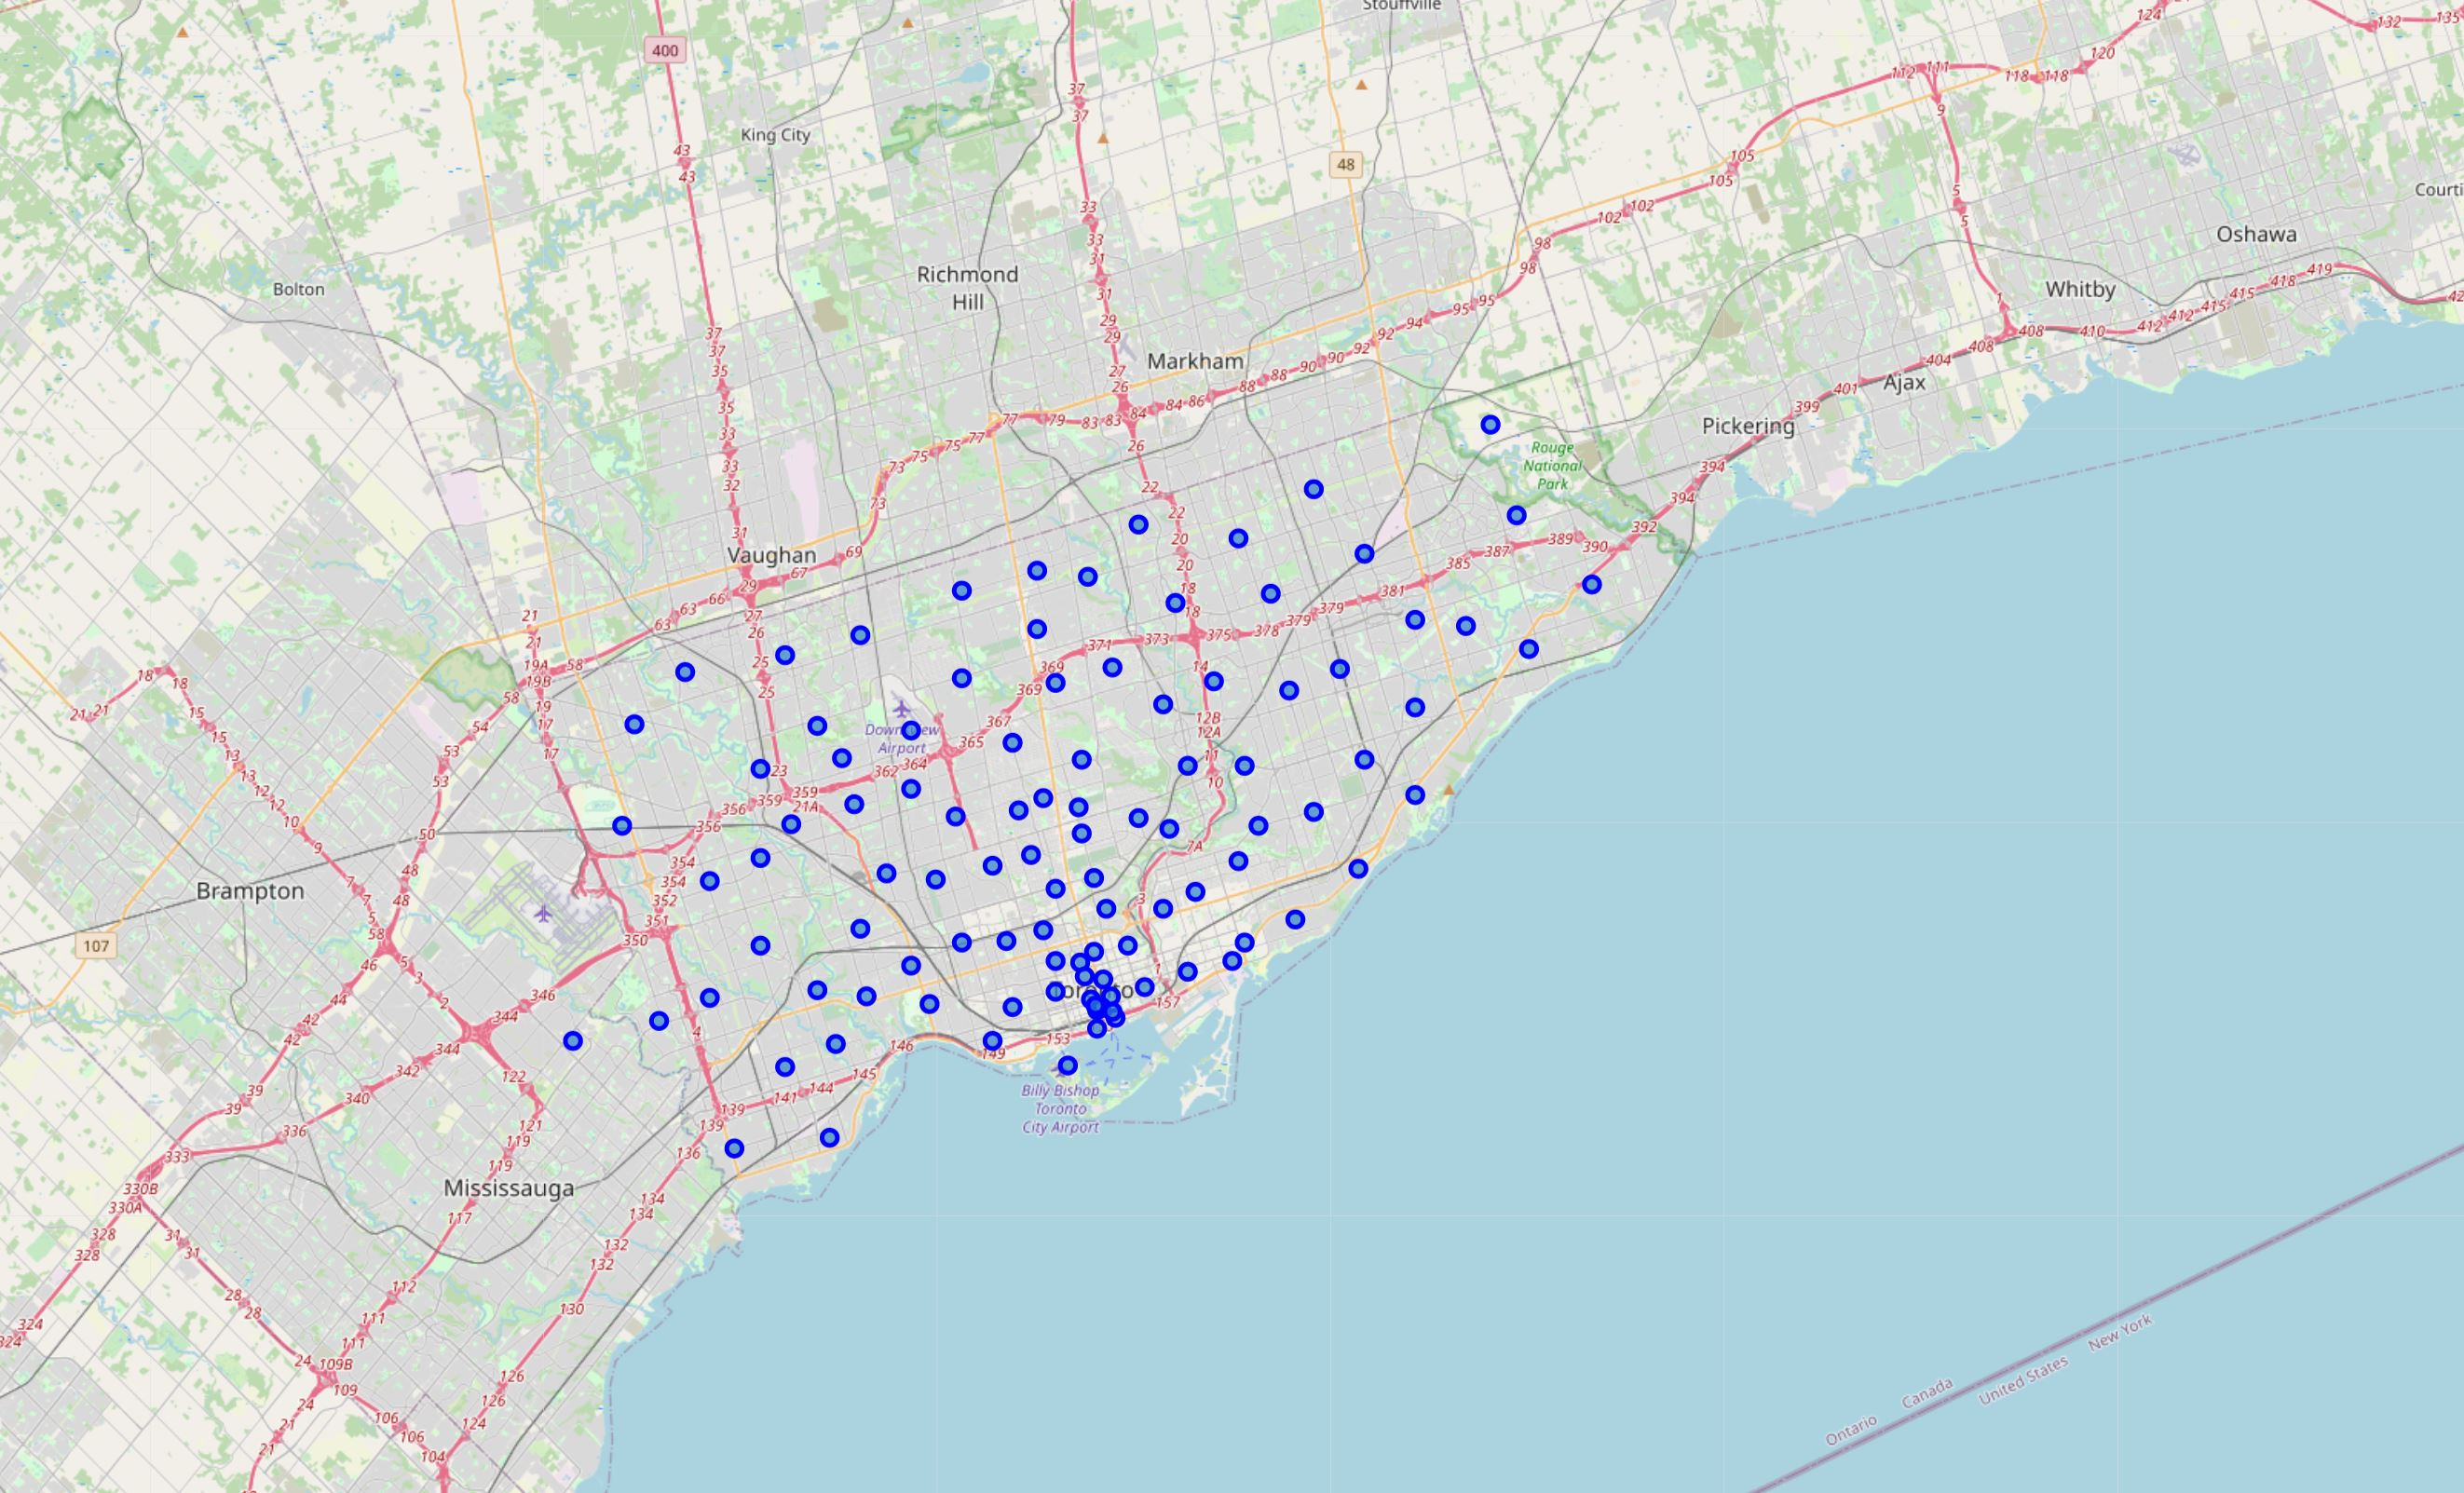

<h2>Exploring neighborhoods with Foursquare API

In [33]:
df_toronto_borough = df[df['Borough'].str.contains("Toronto")].reset_index(drop=True)
df_toronto_borough.shape

(39, 5)

In [30]:
CLIENT_ID = 'KC5EZNA4YUNH1ODPBXNDRBEOV0YF2THCQI00NMEBFSTYGNUU' # your Foursquare ID
CLIENT_SECRET = 'XO1AU3XWVNBMARY3Y0JPORIBWZDGW33IF3F0ZMSXPUBLBHXM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KC5EZNA4YUNH1ODPBXNDRBEOV0YF2THCQI00NMEBFSTYGNUU
CLIENT_SECRET:XO1AU3XWVNBMARY3Y0JPORIBWZDGW33IF3F0ZMSXPUBLBHXM


Get all the venues by borough and neighborhood

In [34]:

def getNearbyVenues(boroughs, neighborhoods, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for borough, neighborhood, lat, lng in zip(boroughs, neighborhoods, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            borough,
            neighborhood, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
                  'Borough',
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [37]:
borough_neighborhood_venues = getNearbyVenues(boroughs=df_toronto_borough['Borough'],
                                             neighborhoods=df_toronto_borough['Neighborhood'],
                                             latitudes=df_toronto_borough['Latitude'],
                                             longitudes=df_toronto_borough['Longitude'])

In [38]:
borough_neighborhood_venues.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Downtown Toronto,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,Downtown Toronto,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,Downtown Toronto,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,Downtown Toronto,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,Downtown Toronto,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


Find how many venues were returned for each borough and neighborhood

In [39]:
borough_neighborhood_venues.groupby(['Borough', 'Neighborhood']).count()

Neighborhood Latitude  \
Borough                Neighborhood                                                                
Central Toronto        Davisville                                                             35   
                       Davisville North                                                        9   
                       Forest Hill North & West                                                4   
                       Lawrence Park                                                           4   
                       Moore Park, Summerhill East                                             1   
                       North Toronto West                                                     22   
                       Roselawn                                                                2   
                       Summerhill West, Rathnelly, South Hill, Forest ...                     13   
                       The Annex, North Midtown, Yorkville                                    22   
Downtown Toronto       Berczy Park                                                            58   
                       CN Tower, King and Spadina, Railway Lands, Harb...                     16   
                       Central Bay Street                                                     67   
                       Christie                                                               16   
                       Church and Wellesley                                                   80   
                       Commerce Court, Victoria Hotel                                        100   
                       First Canadian Place, Underground city                                100   
                       Garden District, Ryerson                                              100   
                       Harbourfront East, Union Station, Toronto Islands                     100   
                       Kensington Market, Chinatown, Grange Park                              68   
                       Regent Park, Harbourfront                                              45   
                       Richmond, Adelaide, King                                               97   
                       Rosedale                                                                4   
                       St. James Town                                                         83   
                       St. James Town, Cabbagetown                                            46   
                       Toronto Dominion Centre, Design Exchange                              100   
                       University of Toronto, Harbord                                         35   
Downtown Toronto Stn A Enclave of M5E                                                         98   
East Toronto           India Bazaar, The Beaches West                                         20   
                       Studio District                                                        37   
                       The Beaches                                                             4   
                       The Danforth West, Riverdale                                           42   
East Toronto Business  Enclave of M4L                                                         17   
East York/East Toronto The Danforth  East                                                      4   
West Toronto           Brockton, Parkdale Village, Exhibition Place                           25   
                       Dufferin, Dovercourt Village                                           14   
                       High Park, The Junction South                                          26   
                       Little Portugal, Trinity                                               41   
                       Parkdale, Roncesvalles                                                 14   
                       Runnymede, Swansea                                  

One hot encoding for each venue category

In [40]:
# one hot encoding
toronto_onehot = pd.get_dummies(borough_neighborhood_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Borough'] = borough_neighborhood_venues['Borough'] 
toronto_onehot['Neighborhoods'] = borough_neighborhood_venues['Neighborhood'] 
toronto_onehot['Venue'] = borough_neighborhood_venues['Venue'] 

# move neighborhood column to the first column
fixed_columns = list(toronto_onehot.columns[-3:]) + list(toronto_onehot.columns[:-3])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Borough,Neighborhoods,Venue,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Downtown Toronto,"Regent Park, Harbourfront",Roselle Desserts,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Downtown Toronto,"Regent Park, Harbourfront",Tandem Coffee,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Downtown Toronto,"Regent Park, Harbourfront",Cooper Koo Family YMCA,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Downtown Toronto,"Regent Park, Harbourfront",Body Blitz Spa East,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Downtown Toronto,"Regent Park, Harbourfront",Impact Kitchen,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by borough and neighborhood and by taking the mean of the frequency of occurrence of each category

In [41]:
toronto_grouped = toronto_onehot.groupby(['Borough', 'Neighborhoods']).mean().reset_index()
toronto_grouped

,Borough,Neighborhoods,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Central Toronto,Davisville,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.00,...,0.00000,0.028571,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Central Toronto,Davisville North,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.00,...,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Central Toronto,Forest Hill North & West,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.00,...,0.00000,0.000000,0.25000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Central Toronto,Lawrence Park,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.00,...,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Central Toronto,"Moore Park, Summerhill East",0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.00,...,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Central Toronto,North Toronto West,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.00,...,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.045455
6,Central Toronto,Roselawn,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.00,...,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",0.0000,0.0000,0.000,0.0000,0.000,0.076923,0.000000,0.00,...,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000
8,Central Toronto,"The Annex, North Midtown, Yorkville",0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.00,...,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Downtown Toronto,Berczy Park,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.00,...,0.00000,0.000000,0.00000,0.00,0.017241,0.000000,0.000000,0.000000,0.000000,0.000000


Let's print each neighborhood along with the top 5 most common venues

In [42]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhoods']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhoods'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[2:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Davisville----
            venue  freq
0     Pizza Place  0.09
1    Dessert Shop  0.09
2            Café  0.09
3  Sandwich Place  0.09
4     Coffee Shop  0.06


----Davisville North----
                  venue  freq
0  Gym / Fitness Center  0.11
1        Breakfast Spot  0.11
2                   Gym  0.11
3                 Hotel  0.11
4     Food & Drink Shop  0.11


----Forest Hill North & West----
              venue  freq
0              Park  0.25
1             Trail  0.25
2     Jewelry Store  0.25
3  Sushi Restaurant  0.25
4           Airport  0.00


----Lawrence Park----
                venue  freq
0                Park  0.25
1            Bus Line  0.25
2  Dim Sum Restaurant  0.25
3         Swim School  0.25
4             Airport  0.00


----Moore Park, Summerhill East----
                      venue  freq
0                Playground   1.0
1                   Airport   0.0
2               Music Store   0.0
3       Martial Arts School   0.0
4  Mediterranean Restaurant   0.0


---

First, let's write a function to sort the venues in descending order.

In [43]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [44]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough', 'Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Borough'] = toronto_grouped['Borough']
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhoods']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 2:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central Toronto,Davisville,Café,Dessert Shop,Sandwich Place,Pizza Place,Gym,Italian Restaurant,Coffee Shop,Sushi Restaurant,Pharmacy,Seafood Restaurant
1,Central Toronto,Davisville North,Gym,Sandwich Place,Park,Gym / Fitness Center,Breakfast Spot,Pizza Place,Department Store,Hotel,Food & Drink Shop,Distribution Center
2,Central Toronto,Forest Hill North & West,Park,Jewelry Store,Trail,Sushi Restaurant,Yoga Studio,Diner,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant
3,Central Toronto,Lawrence Park,Park,Bus Line,Swim School,Dim Sum Restaurant,Discount Store,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant
4,Central Toronto,"Moore Park, Summerhill East",Playground,Yoga Studio,Dim Sum Restaurant,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


<H2>Cluster Neighborhoods

Run k-means to cluster the neighborhood into 5 clusters.

In [46]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop(['Borough', 'Neighborhoods'], 1)

# run k-means clustering
kmeans = KMeans(init='k-means++', n_clusters=kclusters, random_state=1, max_iter=1000).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 1, 0, 2, 0, 3, 0, 0, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [47]:
# add clustering labels
neighborhoods_venues_sorted['Cluster Labels'] = kmeans.labels_

toronto_merged = df_toronto_borough.copy()

# merge toronto_grouped with df_toronto_borough to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.drop(['Borough'], axis=1).set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Coffee Shop,Park,Bakery,Pub,Breakfast Spot,Café,Theater,Dessert Shop,Shoe Store,Restaurant,0
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Italian Restaurant,Middle Eastern Restaurant,Japanese Restaurant,Bubble Tea Shop,Movie Theater,Electronics Store,0
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,Café,Coffee Shop,Cosmetics Shop,Restaurant,Cocktail Bar,Beer Bar,Lingerie Store,Department Store,Creperie,Bakery,0
3,M4E,East Toronto,The Beaches,43.676357,-79.293031,Pub,Health Food Store,Trail,Neighborhood,Yoga Studio,Doner Restaurant,Discount Store,Distribution Center,Dog Run,Dumpling Restaurant,4
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,Cocktail Bar,Bakery,Coffee Shop,Pub,Restaurant,Pharmacy,Seafood Restaurant,Farmers Market,Beer Bar,Cheese Shop,0


Finally, let's visualize the resulting clusters

In [48]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

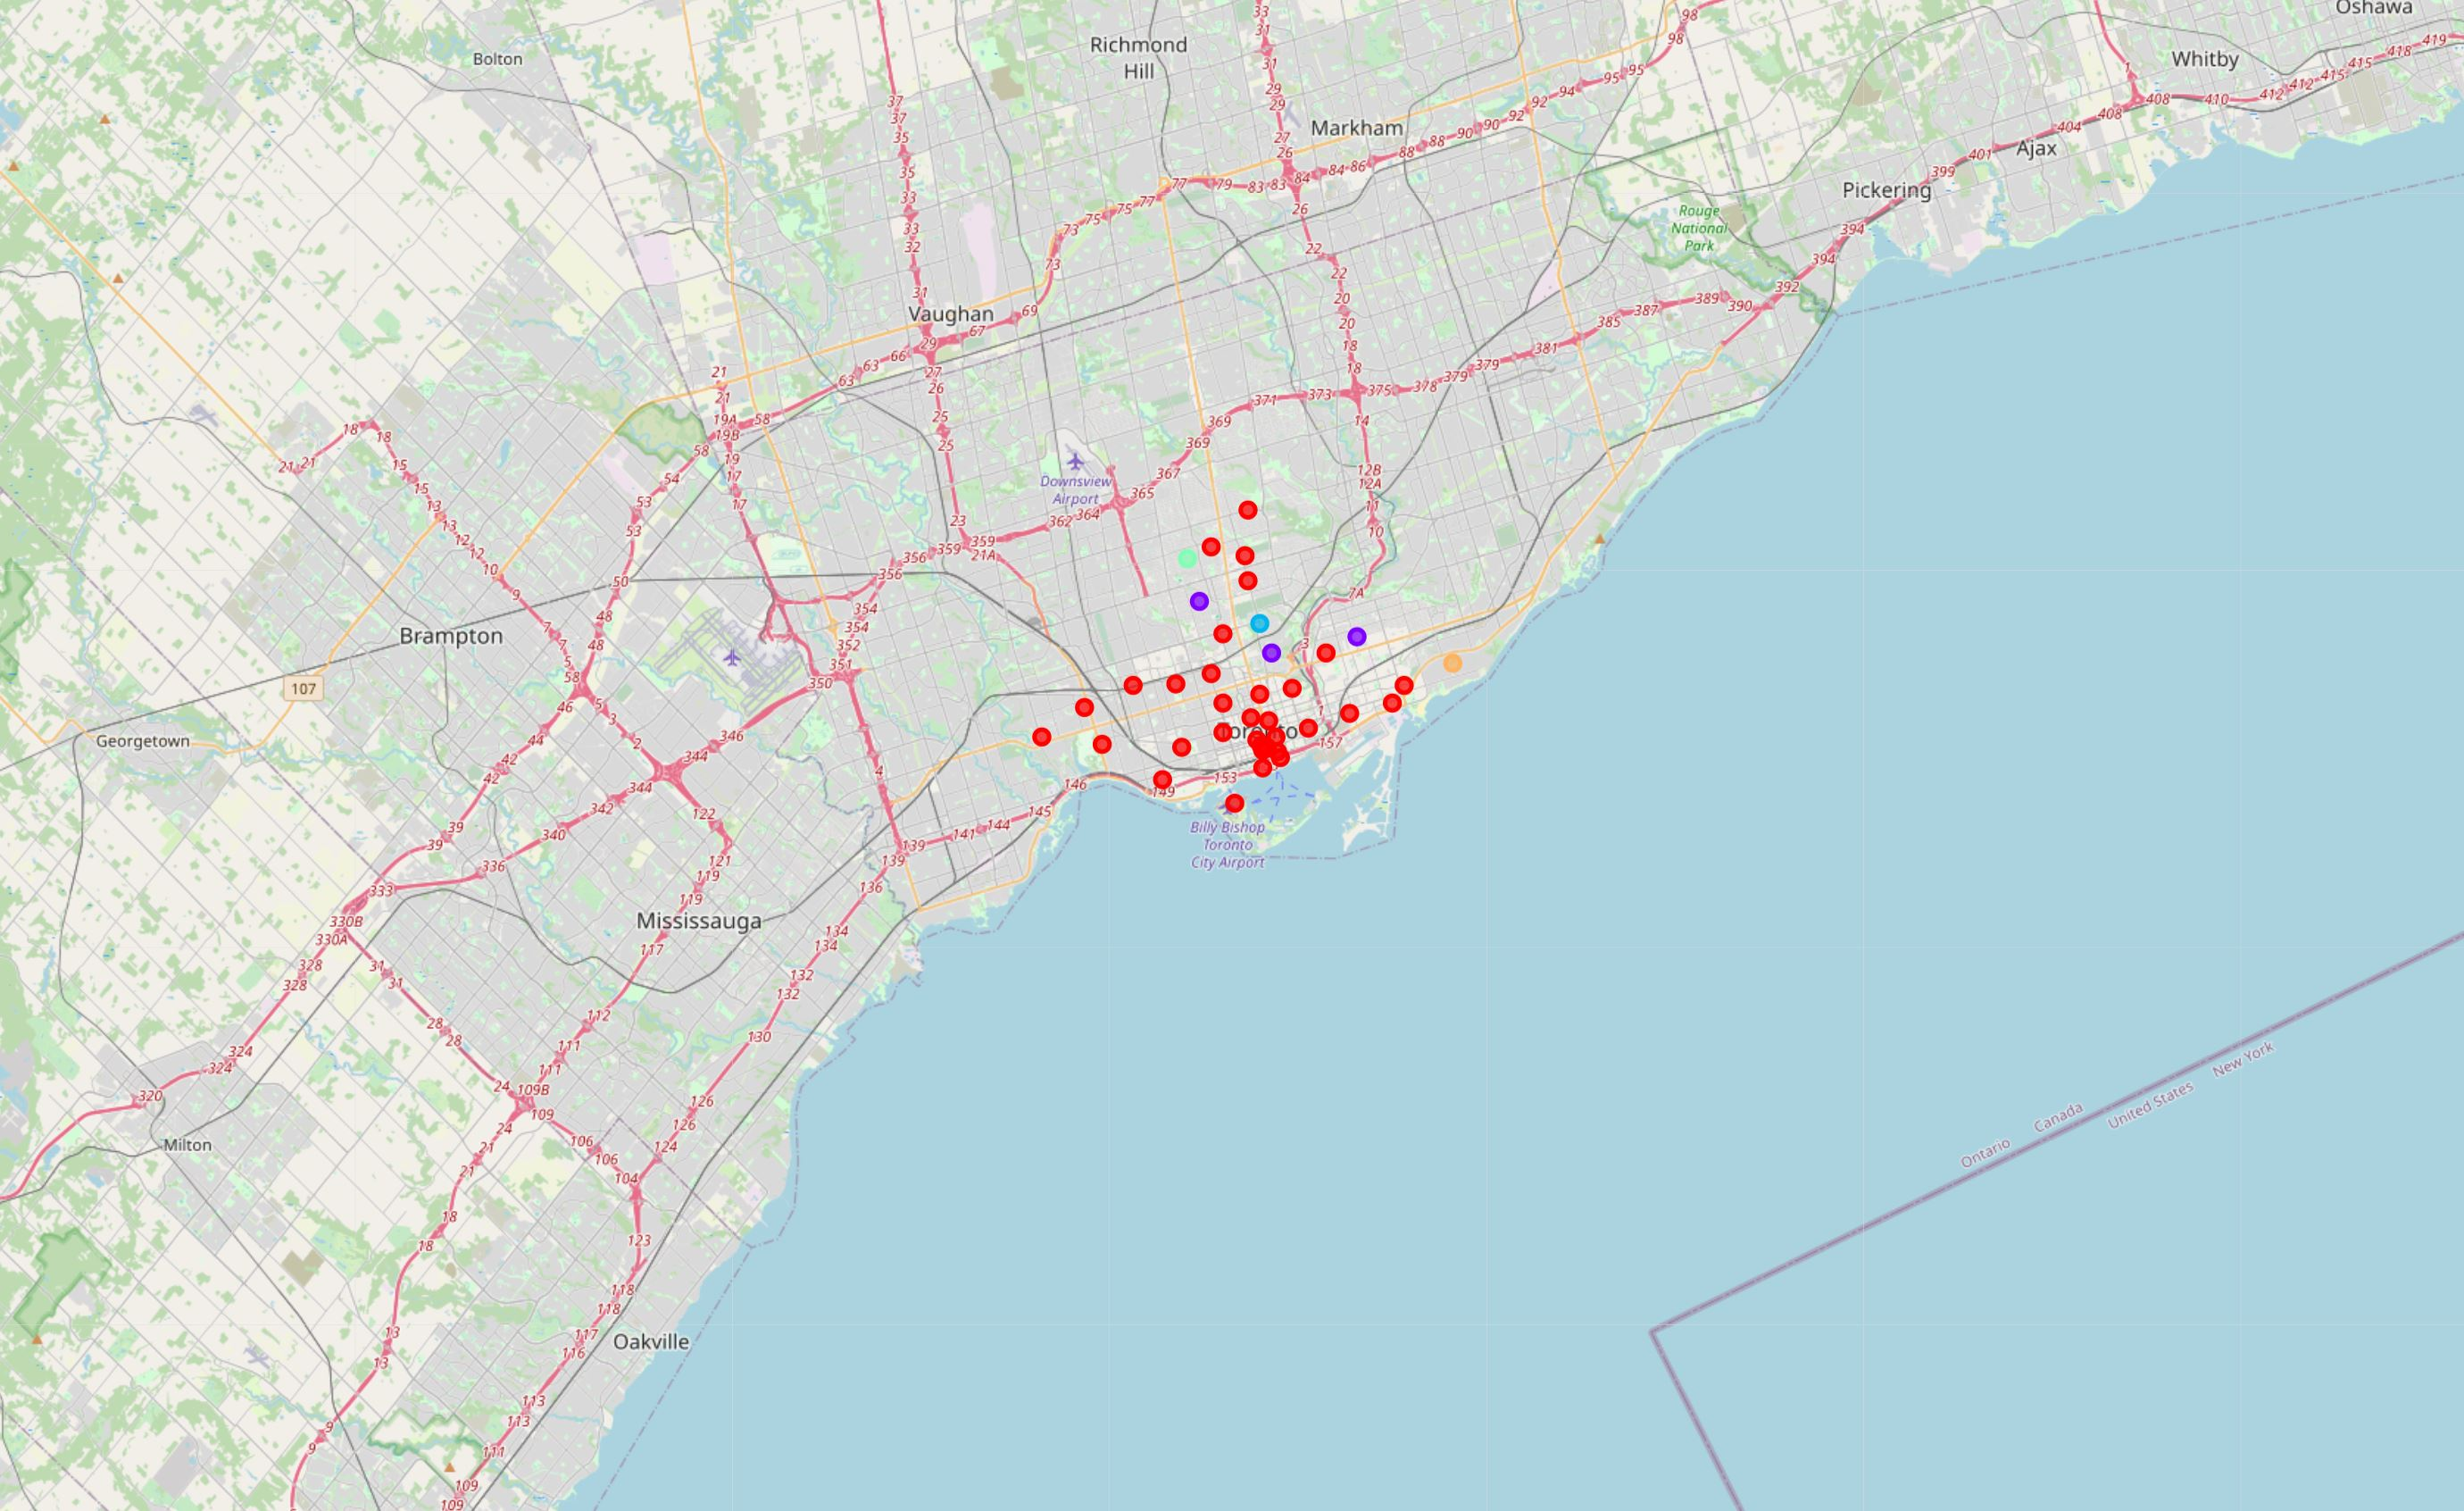

Examining the Clusters

In [49]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Downtown Toronto,Coffee Shop,Park,Bakery,Pub,Breakfast Spot,Café,Theater,Dessert Shop,Shoe Store,Restaurant,0
1,Downtown Toronto,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Italian Restaurant,Middle Eastern Restaurant,Japanese Restaurant,Bubble Tea Shop,Movie Theater,Electronics Store,0
2,Downtown Toronto,Café,Coffee Shop,Cosmetics Shop,Restaurant,Cocktail Bar,Beer Bar,Lingerie Store,Department Store,Creperie,Bakery,0
4,Downtown Toronto,Cocktail Bar,Bakery,Coffee Shop,Pub,Restaurant,Pharmacy,Seafood Restaurant,Farmers Market,Beer Bar,Cheese Shop,0
5,Downtown Toronto,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Salad Place,Bubble Tea Shop,Restaurant,Japanese Restaurant,Burger Joint,Yoga Studio,0
6,Downtown Toronto,Grocery Store,Café,Park,Coffee Shop,Italian Restaurant,Candy Store,Restaurant,Athletics & Sports,Baby Store,Nightclub,0
7,Downtown Toronto,Coffee Shop,Café,Restaurant,Thai Restaurant,Hotel,Deli / Bodega,Gym,American Restaurant,Sushi Restaurant,Burrito Place,0
8,West Toronto,Pharmacy,Bakery,Music Venue,Bank,Middle Eastern Restaurant,Café,Bar,Supermarket,Pet Store,Park,0
10,Downtown Toronto,Coffee Shop,Aquarium,Café,Restaurant,Hotel,Scenic Lookout,Brewery,Fried Chicken Joint,Italian Restaurant,Park,0
11,West Toronto,Bar,Coffee Shop,Asian Restaurant,Restaurant,Café,Men's Store,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Ice Cream Shop,Gift Shop,0


In [50]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
9,East York/East Toronto,Park,Convenience Store,Intersection,Yoga Studio,Discount Store,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,1
21,Central Toronto,Park,Jewelry Store,Trail,Sushi Restaurant,Yoga Studio,Diner,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,1
33,Downtown Toronto,Park,Playground,Trail,Dessert Shop,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,1


In [51]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
29,Central Toronto,Playground,Yoga Studio,Dim Sum Restaurant,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,2


In [52]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
19,Central Toronto,Garden,Fast Food Restaurant,Yoga Studio,Discount Store,Falafel Restaurant,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,3


In [53]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
3,East Toronto,Pub,Health Food Store,Trail,Neighborhood,Yoga Studio,Doner Restaurant,Discount Store,Distribution Center,Dog Run,Dumpling Restaurant,4
